In [1]:
from monty.serialization import loadfn, dumpfn
from pymatgen import Structure, Composition, Element
from pymatgen.entries.computed_entries import ComputedEntry, ComputedStructureEntry
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.entries.entry_tools import EntrySet
from pymatgen.util.plotting import periodic_table_heatmap
from itertools import groupby
from re import sub

In [2]:
scan_entries = loadfn('element_scan_entries_2020-03-23.json')
gga_entries = loadfn('element_gga_entries_2020-03-10.json')

def sort_by_element(entries_list):
    elem_dict = dict()
    for entry in entries_list:
        element = sub(r'[0-9]', '', entry.structure.composition.reduced_formula)
        if not element in elem_dict.keys():
            elem_dict[element] = list([entry])
        else:
            elem_dict[element].append(entry)
    return elem_dict

#Dictionaries where keys are elements and values are lists of entries associated with each element
scan_sorted, gga_sorted = sort_by_element(scan_entries), sort_by_element(gga_entries)

#What elements are missing from scan?
missing_from_scan = list()
for elem in gga_sorted.keys():
    if elem not in scan_sorted.keys():
        missing_from_scan.append(elem)

/home/ayush/pymatgen/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/ayush/pymatgen/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/ayush/pymatgen/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


In [3]:
def get_ground_state(entries_dict):
    gs_dict = dict()
    for element in entries_dict.keys():
        entry_set = EntrySet(entries_dict[element])
        entry_set.remove_non_ground_states()
        gs_dict[element] = list(entry_set)[0]
    return gs_dict

#Key: element, Value: entry corresponding to ground state structure
scan_gs_dict, gga_gs_dict = get_ground_state(scan_sorted), get_ground_state(gga_sorted)

In [4]:
#Key: element, Value: tuple with SCAN & GGA entries of elements with different ground states for SCAN & GGA
def get_diff_dict(scan_gs_dict, gga_gs_dict, ltol=0.2, stol=0.3, angle_tol=5, allow_subset=False):
    matcher = StructureMatcher(ltol, stol, angle_tol, allow_subset)
    diff_dict = dict()
    for element in scan_gs_dict.keys():
        scan_struct, gga_struct = scan_gs_dict[element].structure, gga_gs_dict[element].structure
        if not matcher.fit(scan_struct, gga_struct):
            diff_dict[element] = (scan_gs_dict[element], gga_gs_dict[element])
    return diff_dict

l, s, a, = 0.2, 0.3, 5
k = 2
tolerances = [{'ltol':l  , 'stol':s  , 'angle_tol':a  , 'allow_subset':False},
              {'ltol':l*k, 'stol':s  , 'angle_tol':a  , 'allow_subset':False},
              {'ltol':l  , 'stol':s*k, 'angle_tol':a  , 'allow_subset':False},
              {'ltol':l  , 'stol':s  , 'angle_tol':a*k, 'allow_subset':False},
              {'ltol':l*k, 'stol':s  , 'angle_tol':a*k, 'allow_subset':False},
              {'ltol':l*k, 'stol':s*k, 'angle_tol':a  , 'allow_subset':False},
              {'ltol':l  , 'stol':s*k, 'angle_tol':a*k, 'allow_subset':False},
              {'ltol':l*k, 'stol':s*k, 'angle_tol':a*k, 'allow_subset':False},
              {'ltol':l*k, 'stol':s*k, 'angle_tol':a*k, 'allow_subset':True}]

#entry_configs: list of dictionaries from get_diff_dict(), each corresponds to a 
    #different configuration in the tolerances dict
entry_configs = list()
for config in tolerances:
    diff = get_diff_dict(scan_gs_dict, gga_gs_dict, config['ltol'], config['stol'], config['angle_tol'], config['allow_subset'])
    entry_configs.append(diff)

#energy_configs: list of dictionaries where each key (element) corresponds to a value that represents the 
    #energy difference per atom of scan vs. gga
energy_configs = list()
for i in range(len(entry_configs)):
    d = dict()
    diff = entry_configs[i]
    for elem in diff.keys():
        d[elem] = diff[elem][0].energy_per_atom - diff[elem][1].energy_per_atom
    energy_configs.append(d)

In [5]:
#writes groud state structures to cif files in working directory
def write_to_cif(scan_structs, gga_structs):
    for struct in scan_structs:
        struct.to(fmt=".cif", filename='cif_files/scan/{0}_scan.cif'.format(struct.composition.reduced_formula))
    for struct in gga_structs:
        struct.to(fmt=".cif", filename='cif_files/gga/{0}_gga.cif'.format(struct.composition.reduced_formula))

StructureMatcher Settings: {'ltol': 0.2, 'stol': 0.3, 'angle_tol': 5, 'allow_subset': False}
Elements (33): ['Al', 'Ar', 'As', 'Au', 'Be', 'C', 'Ca', 'Ce', 'Co', 'Cs', 'F', 'H', 'Hg', 'Ho', 'In', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'Pa', 'Pr', 'Rb', 'S', 'Sb', 'Se', 'Tc', 'Tl', 'Tm', 'Xe', 'Yb']


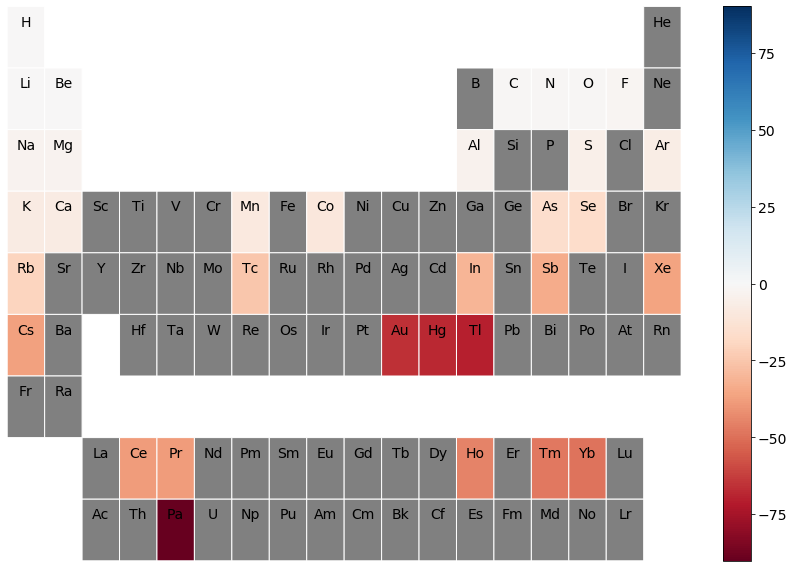

StructureMatcher Settings: {'ltol': 0.4, 'stol': 0.6, 'angle_tol': 10, 'allow_subset': True}
Elements (26): ['Al', 'Ar', 'As', 'Au', 'Co', 'Cs', 'H', 'Hg', 'Ho', 'In', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Pr', 'Rb', 'S', 'Sb', 'Se', 'Tc', 'Tl', 'Tm', 'Xe', 'Yb']


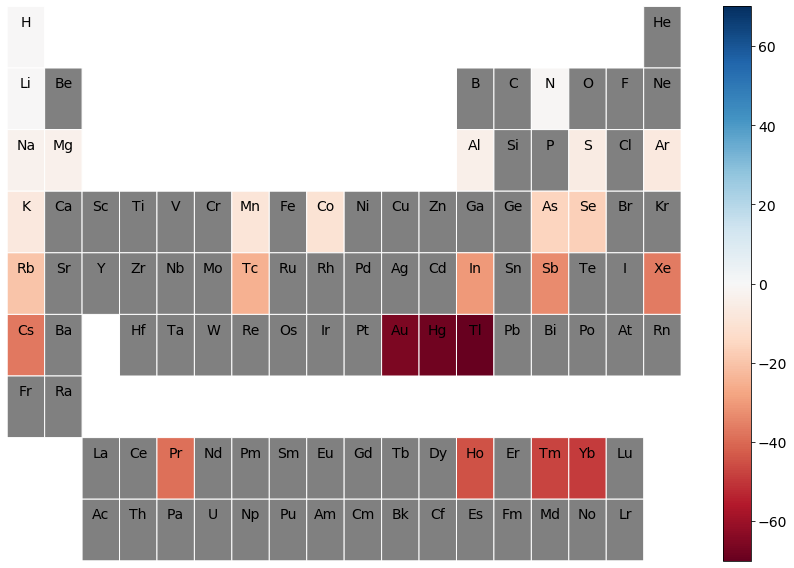

In [6]:
full = range(len(energy_configs))
first_last = [0, -1]
first = [0]
last = [-1]

#display periodic table heatmap using dicts in energy_configs
for i in first_last:
    print('StructureMatcher Settings:', tolerances[i])
    keys = list(energy_configs[i].keys())
    print('Elements ({0}):'.format(len(keys)), keys)
    maxval = max([abs(e) for e in energy_configs[i].values()]) #used to center color scale at 0
    periodic_table_heatmap(energy_configs[i], show_plot=True, cmap='RdBu', cmap_range=(-maxval, maxval))

In [7]:
print(len(energy_configs[0])) #lowest tolerance - most number of different ground states
print(len(energy_configs[-1])) #highest tolerance - least number of different ground states

33
26


In [8]:
display_elem = lambda elem: print(str(scan_gs_dict[elem]) + '\n\n' + str(gga_gs_dict[elem])) 

#display differences between low tolerance and high tolerance sets
low_tol_set = set(energy_configs[0].keys())
high_tol_set = set(energy_configs[-1].keys())
diff_set = low_tol_set.difference(high_tol_set)
print(diff_set)
for elem in diff_set:
    print('--------------------------------')
    display_elem(elem)

{'Ca', 'F', 'C', 'Be', 'O', 'Ce', 'Pa'}
--------------------------------
ComputedStructureEntry 6664 - Ca2
Energy = -19.3520
Correction = 0.0000
Parameters:
run_type = SCAN
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'd468193c046ca474632d44f0ce9c97c9'}]
is_hubbard = False
hubbards = {}
pseudo_potential = {'functional': 'pbe', 'pot_type': 'paw', 'labels': ['Ca_sv']}
Data:

ComputedStructureEntry mp-1064227 - Ca4
Energy = -8.0092
Correction = 0.0000
Parameters:
run_type = GGA
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}]
is_hubbard = False
hubbards = {}
pseudo_potential = {'functional': 'pbe', 'pot_type': 'paw', 'labels': ['Ca_sv']}
Data:
--------------------------------
ComputedStructureEntry 6458 - F4
Energy = -14.2151
Correction = 0.0000
Parameters:
run_type = SCAN
potcar_spec = [{'titel': 'PAW_PBE F 08Apr2002', 'hash': '5c4eeeaf2c4337bde6e8725019a3450e'}]
is_hubbard = False
hubbards = {}
pseudo_potential = {'functiona

In [9]:
missing_from_scan

['He']

In [10]:
focus_list = entry_configs[0] #which set of tolerances to use?
gs_energy_diff = dict()
problematic_elements = list()
m = StructureMatcher()

'''
gs_energy_diff is a dict
key = element
value:
(energy_per_atom of the SCAN ground state minus energy_per_atom of the unstable SCAN polymorph that is also the GGA ground state)
minus
(energy_per_atom of the unstable GGA polymorph that is also the SCAN ground state minus energy_per_atom of GGA ground state)

--->matching done with StructureMatcher
'''

for elem in focus_list.keys():
    scan_gs = scan_gs_dict[elem]
    gga_gs = gga_gs_dict[elem]
    
    matching_in_gga = None
    matching_in_scan = None
    
    for entry in gga_sorted[elem]:
        if m.fit(scan_gs.structure, entry.structure):
            matching_in_gga = entry
            break
            
    for entry in scan_sorted[elem]:
        if m.fit(gga_gs.structure, entry.structure):
            matching_in_scan = entry
            break
            
    if matching_in_gga and matching_in_scan:
        gs_energy_diff[elem] = (scan_gs.energy_per_atom - matching_in_scan.energy_per_atom) - (matching_in_gga.energy_per_atom - gga_gs.energy_per_atom)
    else:
        problematic_elements.append((elem, True if matching_in_gga else False, True if matching_in_scan else False))

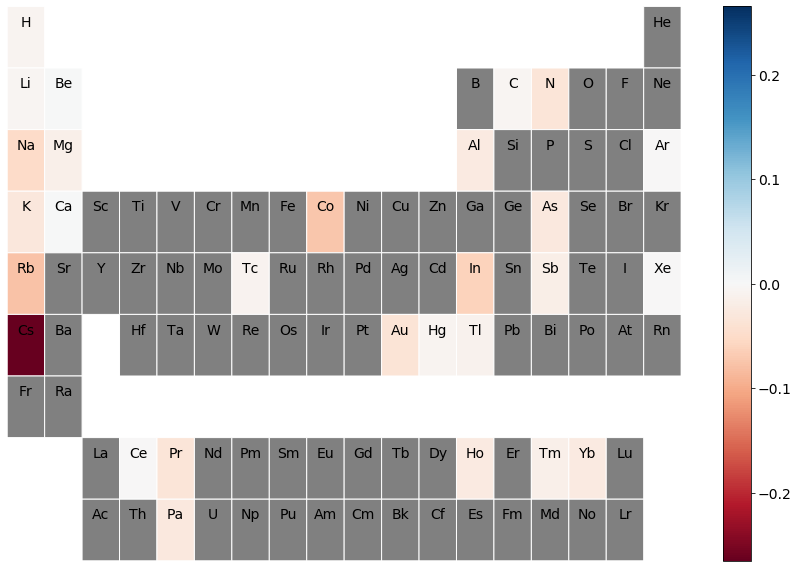

<module 'matplotlib.pyplot' from '/home/ayush/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [11]:
maxval1 = max([abs(e) for e in gs_energy_diff.values()]) #used to center color scale at 0
periodic_table_heatmap(gs_energy_diff, show_plot=True, cmap='RdBu', cmap_range=(-maxval1, maxval1))

In [12]:
problematic_elements
# Element, scan gs present in gga?, gga gs present in scan?

[('F', True, False),
 ('Mn', True, False),
 ('O', False, False),
 ('S', True, False),
 ('Se', True, False)]

In [17]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

focus_list = entry_configs[0]
gs_energy_diff_spg = dict()
problematic_elements_spg = list()

'''
gs_energy_diff_spg is a dict
key = element
value:
(energy_per_atom of the SCAN ground state minus energy_per_atom of the unstable SCAN polymorph that is also the GGA ground state)
minus
(energy_per_atom of the unstable GGA polymorph that is also the SCAN ground state minus energy_per_atom of GGA ground state)

--->matching done with SpacegroupAnalyzer
'''

for elem in focus_list.keys():
    scan_gs = scan_gs_dict[elem]
    gga_gs = gga_gs_dict[elem]
    
    matching_in_gga = None
    matching_in_scan = None
    
    for entry in gga_sorted[elem]:
        if SpacegroupAnalyzer(scan_gs.structure).get_space_group_symbol() ==  SpacegroupAnalyzer(entry.structure).get_space_group_symbol():
            matching_in_gga = entry
            break
            
    for entry in scan_sorted[elem]:
        if SpacegroupAnalyzer(gga_gs.structure).get_space_group_symbol() ==  SpacegroupAnalyzer(entry.structure).get_space_group_symbol():
            matching_in_scan = entry
            break
            
    if matching_in_gga and matching_in_scan:
        gs_energy_diff_spg[elem] = (scan_gs.energy_per_atom - matching_in_scan.energy_per_atom) - (matching_in_gga.energy_per_atom - gga_gs.energy_per_atom)
    else:
        problematic_elements_spg.append((elem, True if matching_in_gga else False, True if matching_in_scan else False))

In [18]:
problematic_elements_spg

[('Au', False, True),
 ('Ca', True, False),
 ('Mn', True, False),
 ('S', True, False)]

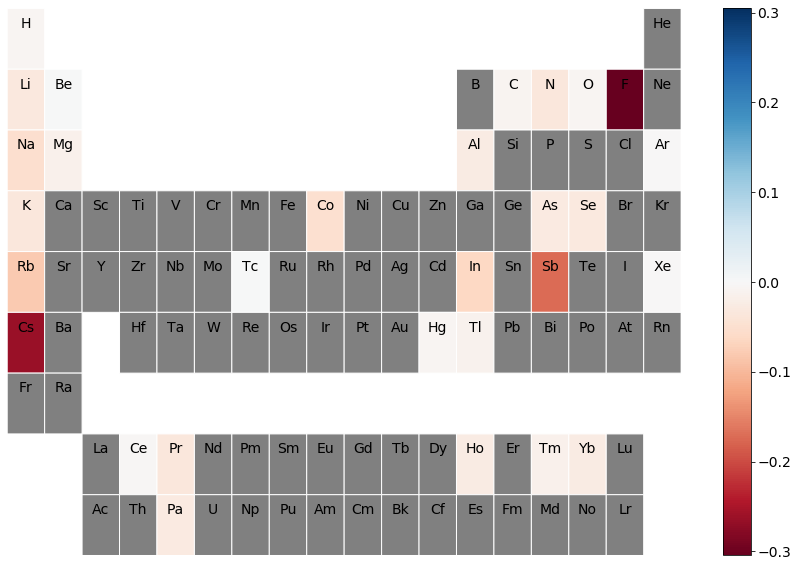

<module 'matplotlib.pyplot' from '/home/ayush/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [19]:
maxval2 = max([abs(e) for e in gs_energy_diff_spg.values()]) #used to center color scale at 0
periodic_table_heatmap(gs_energy_diff_spg, show_plot=True, cmap='RdBu', cmap_range=(-maxval2, maxval2))